In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
video1_path = "one.mp4"
video2_path = "two.mp4"

cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

if not cap1.isOpened() or not cap2.isOpened():
    raise RuntimeError("Error opening one or both videos")

def preprocess(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return frame, gray

print("Preprocess function defined successfully.")

frame_idx = 0

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    frame1_p, gray1 = preprocess(frame1)
    frame2_p, gray2 = preprocess(frame2)

    target_size = (1280, 720)
    frame1_p = cv2.resize(frame1_p, target_size)
    frame2_p = cv2.resize(frame2_p, target_size)
    gray1 = cv2.resize(gray1, target_size)
    gray2 = cv2.resize(gray2, target_size)
    frame_idx += 1

cap1.release()
cap2.release()

print(f"Preprocessed {frame_idx} synchronized frames")


Preprocess function defined successfully.
Preprocessed 525 synchronized frames


In [29]:
sift = cv2.SIFT_create()

cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

ret1, frame1 = cap1.read()
ret2, frame2 = cap2.read()

if not ret1 or not ret2:
    raise RuntimeError("Cannot read first frames")

# Preprocess
_, gray1 = preprocess(frame1)
_, gray2 = preprocess(frame2)

# SIFT
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Video1 (frame0): {len(kp1)} keypoints")
print(f"Video2 (frame0): {len(kp2)} keypoints")

cap1.release()
cap2.release()

Video1 (frame0): 9194 keypoints
Video2 (frame0): 5697 keypoints


Video1 frame0 keypoints: 9194
Video2 frame0 keypoints: 5697


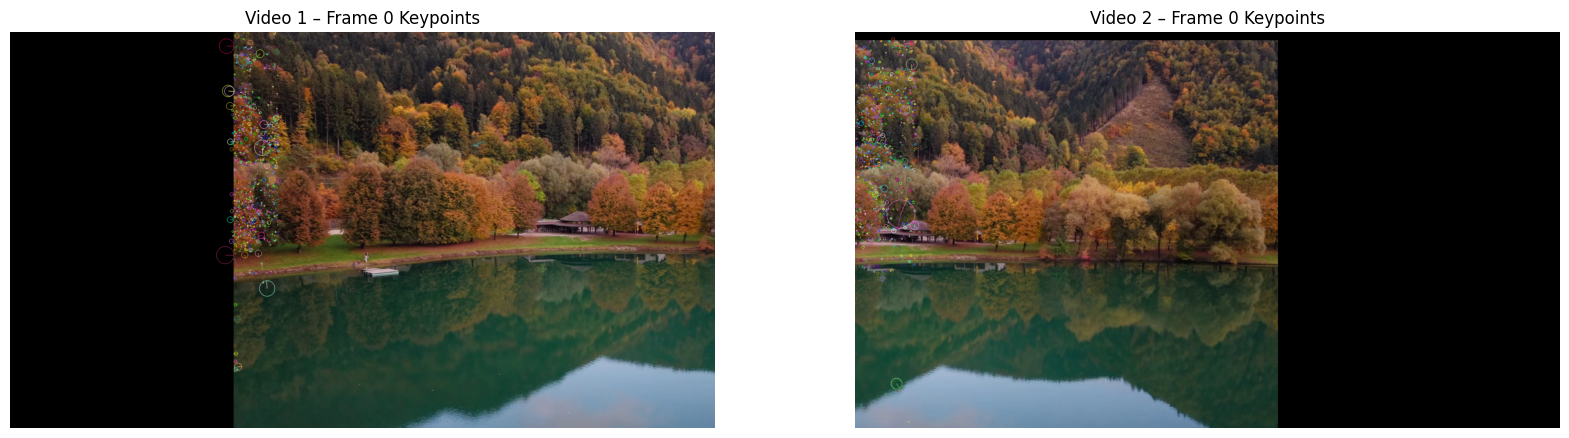

In [30]:
cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

ret1, frame1 = cap1.read()
ret2, frame2 = cap2.read()

cap1.release()
cap2.release()

if not ret1 or not ret2:
    raise RuntimeError("Could not read first frame from videos")

img1_p, gray1 = preprocess(frame1)
img2_p, gray2 = preprocess(frame2)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Video1 frame0 keypoints: {len(kp1)}")
print(f"Video2 frame0 keypoints: {len(kp2)}")

img1_kp = cv2.drawKeypoints(
    img1_p, kp1[:1000], None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

img2_kp = cv2.drawKeypoints(
    img2_p, kp2[:1000], None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

img1_kp_rgb = cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB)
img2_kp_rgb = cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB)

# --- Display ---
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img1_kp_rgb)
plt.title("Video 1 – Frame 0 Keypoints")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_kp_rgb)
plt.title("Video 2 – Frame 0 Keypoints")
plt.axis("off")

plt.show()

In [31]:
import cv2

bf = cv2.BFMatcher(cv2.NORM_L2)

matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
ratio_thresh = 0.75

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print(f"Total matches: {len(matches)}")
print(f"Good matches after ratio test: {len(good_matches)}")

Total matches: 9194
Good matches after ratio test: 2362


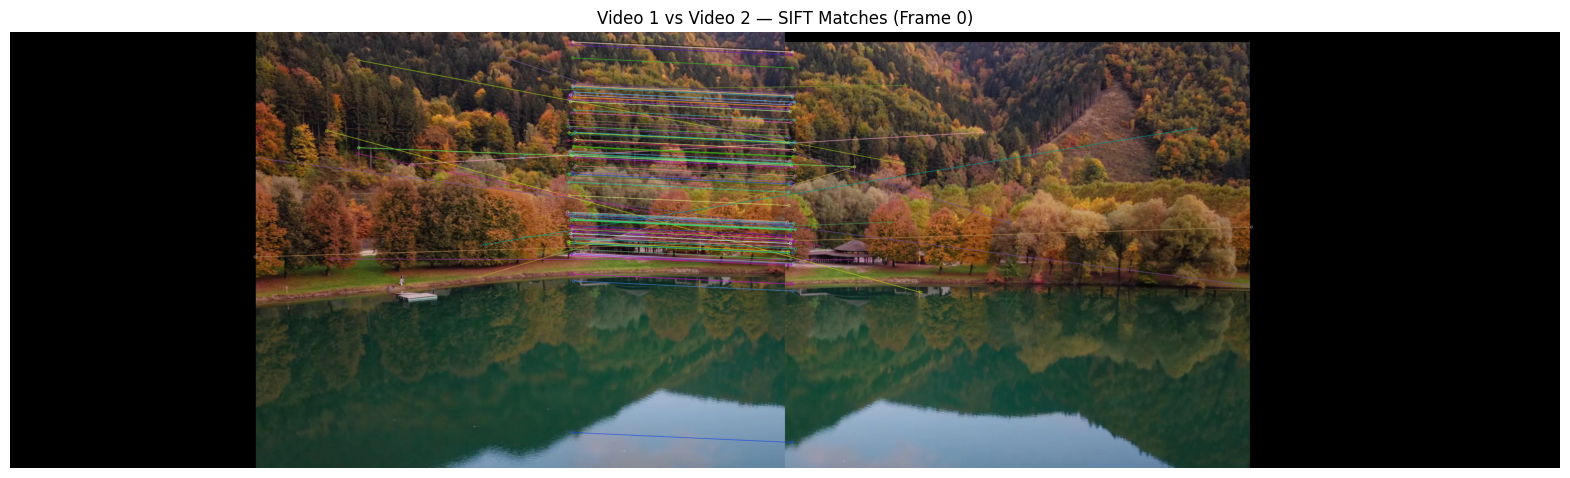

In [32]:
img_matches = cv2.drawMatches(
    img1_p, kp1,
    img2_p, kp2,
    good_matches[:100], None, 
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# BGR → RGB
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(20, 10))
plt.imshow(img_matches_rgb)
plt.title("Video 1 vs Video 2 — SIFT Matches (Frame 0)")
plt.axis('off')
plt.show()

In [33]:
def estimate_homography_ransac(kp1, kp2, good_matches, inlier_ratio=0.5):
    if len(good_matches) < 4:
        return None, False, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(
        src_pts,
        dst_pts,
        cv2.RANSAC,
        ransacReprojThreshold=5.0
    )

    if H is None or mask is None:
        return None, False, None

    inliers = int(mask.ravel().sum())
    total = len(mask)
    ratio = inliers / total

    print(f"Inliers: {inliers}/{total} ({ratio:.2f})")

    if ratio < inlier_ratio:
        return None, False, None

    return H, True, mask

In [34]:
H, ok, mask = estimate_homography_ransac(kp1, kp2, good_matches)

if not ok:
    raise RuntimeError("Homography estimation failed")

print("Homography matrix:\n", H)

Inliers: 2333/2362 (0.99)
Homography matrix:
 [[ 9.99764244e-01  4.41276606e-05 -1.37575541e+03]
 [-3.27683379e-05  9.99900193e-01  2.47695111e+01]
 [-1.06822407e-07  6.38823972e-08  1.00000000e+00]]


In [35]:
def recompute_homography_inliers(kp1, kp2, matches, inlier_mask):
    
    inlier_mask = inlier_mask.ravel().astype(bool)

    inlier_matches = [m for i, m in enumerate(matches) if inlier_mask[i]]

    if len(inlier_matches) < 4:
        return None, []

    src_pts = np.float32(
        [kp1[m.queryIdx].pt for m in inlier_matches]
    ).reshape(-1, 1, 2)

    dst_pts = np.float32(
        [kp2[m.trainIdx].pt for m in inlier_matches]
    ).reshape(-1, 1, 2)

    H_refined, _ = cv2.findHomography(src_pts, dst_pts, method=0)

    return H_refined, inlier_matches

In [36]:
H_init, ok, mask = estimate_homography_ransac(kp1, kp2, good_matches)

if not ok:
    raise RuntimeError("Initial homography failed")

H_refined, inlier_matches = recompute_homography_inliers(
    kp1, kp2, good_matches, mask
)

if H_refined is None:
    raise RuntimeError("Homography refinement failed")

print("Refined Homography:\n", H_refined)
print("Inlier matches:", len(inlier_matches))

Inliers: 2333/2362 (0.99)
Refined Homography:
 [[ 9.99764244e-01  4.41276606e-05 -1.37575541e+03]
 [-3.27683379e-05  9.99900193e-01  2.47695111e+01]
 [-1.06822407e-07  6.38823972e-08  1.00000000e+00]]
Inlier matches: 2333


In [37]:
cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

ret1, frame1 = cap1.read()
ret2, frame2 = cap2.read()

if not ret1 or not ret2:
    raise RuntimeError("Cannot read first frames")

img1_p, gray1 = preprocess(frame1)
img2_p, gray2 = preprocess(frame2)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

H, success, inlier_mask = estimate_homography_ransac(
    kp1, kp2, good_matches
)

if not success:
    raise RuntimeError("Homography estimation failed")

H_refined, inlier_matches = recompute_homography_inliers(
    kp1, kp2, good_matches, inlier_mask
)

if H_refined is None:
    raise RuntimeError("Homography refinement failed")

print("Refined homography:\n", H_refined)
print("Inlier matches:", len(inlier_matches))

Inliers: 2333/2362 (0.99)
Refined homography:
 [[ 9.99764244e-01  4.41276606e-05 -1.37575541e+03]
 [-3.27683379e-05  9.99900193e-01  2.47695111e+01]
 [-1.06822407e-07  6.38823972e-08  1.00000000e+00]]
Inlier matches: 2333


In [38]:
def warp_images(video1_path, video2_path, H):
    h1, w1 = video1_path.shape[:2]
    h2, w2 = video2_path.shape[:2]

    corners_img1 = np.float32([
        [0, 0],
        [w1, 0],
        [w1, h1],
        [0, h1]
    ]).reshape(-1, 1, 2)

    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    corners_img2 = np.float32([
        [0, 0],
        [w2, 0],
        [w2, h2],
        [0, h2]
    ]).reshape(-1, 1, 2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = np.array([
        [1, 0, -xmin],
        [0, 1, -ymin],
        [0, 0, 1]
    ])

    result = cv2.warpPerspective(
        video1_path,
        translation @ H,
        (xmax - xmin, ymax - ymin)
    )

    result[-ymin:h2 - ymin, -xmin:w2 - xmin] = video2_path

    return result

In [39]:
cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

fps = cap1.get(cv2.CAP_PROP_FPS)

ret1, frame1 = cap1.read()
ret2, frame2 = cap2.read()

stitched = warp_images(frame1, frame2, H_refined)
h_out, w_out = stitched.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("stitched_output.mp4", fourcc, fps, (w_out, h_out))

out.write(stitched)

frame_idx = 1
while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    stitched = warp_images(frame1, frame2, H_refined)
    out.write(stitched)

    frame_idx += 1

cap1.release()
cap2.release()
out.release()

print(f"Stitched video saved (frames: {frame_idx})")

Stitched video saved (frames: 525)
